In [2]:
from imports import *
from data import *
from arch import *
model = return_token_model(CORE_MODEL, len(labels), preferred_cuda_test);
#model.load_state_dict(torch.load(CHECKPOINT_PATH + ROOT_NAME + '3_17000.pt')["model_state_dict"]);
#model.load_state_dict(torch.load("/mnt/SSD2/pholur/CTs/checkpoints/Day_0928_Insider_Outsider_79_54480.pt")["model_state_dict"]);
model.load_state_dict(torch.load("/mnt/SSD2/pholur/CTs/checkpoints/Day_0928_Insider_Outsider_20_14301.pt")["model_state_dict"]);
model.eval();

/home/pholur/miniconda3/envs/sit/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/pholur/miniconda3/envs/sit/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/pholur/miniconda3/envs/sit/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/pholur/miniconda3/envs/sit/lib/python3.7/site-

In [3]:
from shared_train_and_test_functions import tokenization
import spacy
from spacy import displacy
import nltk
nlp = spacy.load('en_core_web_sm')
# ONLY WORKS FOR SINGLE POST TESTING

In [4]:
def return_insiders_and_outsiders(text, option_display=False):
    doc = nlp(text)
    add_np_text = []
    spans = []
    for npy in doc.noun_chunks:
        add_np_text.append(npy.text)
        spans.append((npy.start_char, npy.end_char))

    test_encodings, tokens = tokenization([text], True)
    offset_mappings = test_encodings.offset_mapping[0]

    input_ids = torch.tensor(test_encodings['input_ids']).to(preferred_cuda_test)
    attention_mask = torch.tensor(test_encodings['attention_mask']).to(preferred_cuda_test)
    outputs = model(input_ids, attention_mask=attention_mask) # try this: labels = torch.tensor([0]*len(input_ids)).to(preferred_cuda_test))
    predictions = outputs[0].detach().cpu().numpy()
    single_prediction_post = predictions[0]
    predictions_argmax = np.argmax(single_prediction_post, axis=1)
    # print(predictions_argmax)
    # print(outputs)
    ents = []
    total_true = {}

    for i in range(len(spans)):
        total_true[i] = False
    
    for j in range(len(spans)):
        
        choice = "no"
        for i,index in enumerate(predictions_argmax):
            current_token_mapping = offset_mappings[i]
 
            if current_token_mapping[0] >= spans[j][0] and current_token_mapping[1] <= spans[j][1]: # if the token is in the span of a chunk
                if index == 2:
                    choice = "yes"
                else:
                    choice = "no"

        if choice == "no":
            ents.append({"start": spans[j][0], "end": spans[j][1], "label": "INSIDER"})
        else:
            ents.append({"start": spans[j][0], "end": spans[j][1], "label": "OUTSIDER"})

    # deduplicate list of dictionaries
    ents = [dict(t) for t in {tuple(d.items()) for d in ents}]
    # sort list of dictionaries by start index
    ents = sorted(ents, key=lambda x: x['start'])
    #print(ents)
    options = {"colors": {"INSIDER":"#88C6F1", "OUTSIDER":"#FF82AB"}}
    ex = [{"text": text, "ents": ents}]
    if option_display == True:
        displacy.render(ex, style="ent", manual=True, options=options)
        return None
    else:
        dictionary_map = {}
        for ent in ents:
            dictionary_map[text[ent['start']:ent['end']]] = ent['label']
        return dictionary_map

In [5]:
#posts = ["I think that #BigTech will kill me with vaccines. People like Bill Gates are doing it for the money. My friend, Sarah, who is a doctor, told me not to get the vaccine, because it causes cancer."]
posts = ["5g causes cancer", "5g is good for the economy.", "We should burn cell phone towers.", "We should build cell phone towers.", "Radio waves are as potent as vaccines.", "Vaccines are not harmful.", "Microchips are telling the government where we are 24/7.", "Vaccines contain microchips.", \
    ">doesn't make sense how is wanting safety for a new experimental drug not make sense? even if you got the vaccine you still run risk to get covid, need to isolate and wear a mask, and still have the same risk of death. the company even hid any side effects and threatened to sue anyone mentioning side effects. the people taking the vaccine now are just part of the testing trials, they are volunteer test subjects, since we don't even know long term effects or any effect past 1 year of taking it"]
#posts = ["I think that #BigTech will save me with vaccines. People like Bill Gates are doing it to save people. My friend, Sarah, who is a doctor, told me to get the vaccine, because it does not causes small pox."]
for p in posts:
    return_insiders_and_outsiders(p, True)

/home/pholur/miniconda3/envs/sit/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2227: UserWarning: `max_length` is ignored when `padding`=`True`.
  warnings.warn("`max_length` is ignored when `padding`=`True`.")


In [6]:
test_loss = 0
number_of_test_batches = 0
test_loader = get_data(INPUT_DATA_PATH, FLAG, AUG, REEXTRACT, FRACTION, "test")

for j,test_batch in enumerate(test_loader):
    input_ids = test_batch['input_ids'].to(preferred_cuda_test)
    attention_mask = test_batch['attention_mask'].to(preferred_cuda_test)
    labels = test_batch['labels'].to(preferred_cuda_test)
    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        test_loss += outputs[0]
    number_of_test_batches += 1
print("Total test loss:", test_loss/number_of_test_batches)

Using separate samples per entity: Size =  648
Total test loss: tensor(0.8864, device='cuda:1')


In [7]:
import pandas as pd
df = pd.read_csv(INPUT_DATA_PATH)
df.head()

,PostID,SentenceID,NP_ID,Post,Sentence,NP,Modified_Post,Modified_Sentence,Question,AnswerA,AnswerB,AnswerC,id,sentiment,annotator,annotation_id
0,6286,3,0,Why is he talking about Vaccine and Viruses? H...,"If I need info about vaccine, I can easily get...",I,Why is he talking about Vaccine and Viruses? H...,"<b>I</b>f <b>I</b> need info about vaccine, <b...",Does the *** AUTHOR *** think that I(in bold) ...,Author thinks I(in bold) is a GOOD entity.,Author thinks I(in bold) is a BAD entity.,I can't resolve what the Author thinks about I...,111867,$AnswerA,solutions@solutions.com,706
1,4999,3,3,>PCR testing standards were changed on inaugur...,"By the way, can you tell me what standards wer...",what standards,>PCR testing standards were changed on inaugur...,"By the way, can you tell me <b>what standards<...",Does the *** AUTHOR *** think that what standa...,Author thinks what standards(in bold) is a GOO...,Author thinks what standards(in bold) is a BAD...,I can't resolve what the Author thinks about w...,91315,$AnswerC,solutions@solutions.com,646
2,1924,0,5,cant believe im looking forward to th 911 trut...,cant believe im looking forward to th 911 trut...,death,<b>cant believe im looking forward to th 911 t...,cant believe im looking forward to th 911 trut...,Does the *** AUTHOR *** think that death(in bo...,Author thinks death(in bold) is a GOOD entity.,Author thinks death(in bold) is a BAD entity.,I can't resolve what the Author thinks about d...,42971,$AnswerB,solutions@solutions.com,1709
3,1924,0,5,cant believe im looking forward to th 911 trut...,cant believe im looking forward to th 911 trut...,death,<b>cant believe im looking forward to th 911 t...,cant believe im looking forward to th 911 trut...,Does the *** AUTHOR *** think that death(in bo...,Author thinks death(in bold) is a GOOD entity.,Author thinks death(in bold) is a BAD entity.,I can't resolve what the Author thinks about d...,42971,$AnswerB,solutions@solutions.com,667
4,1924,0,5,cant believe im looking forward to th 911 trut...,cant believe im looking forward to th 911 trut...,death,<b>cant believe im looking forward to th 911 t...,cant believe im looking forward to th 911 trut...,Does the *** AUTHOR *** think that death(in bo...,Author thinks death(in bold) is a GOOD entity.,Author thinks death(in bold) is a BAD entity.,I can't resolve what the Author thinks about d...,42971,$AnswerB,solutions@solutions.com,665


In [8]:
posts = list(set(df['Post'].tolist()))
print(len(posts))
from tqdm import tqdm
# find relevant entities
ents = {}
for i,p in tqdm(enumerate(posts[:])):
    returned_dictionary = return_insiders_and_outsiders(p, False)
    for key in returned_dictionary:
        key_ = key.lower()
        if key_ not in ents:
            ents[key_] = [returned_dictionary[key]]
        else:
            ents[key_].append(returned_dictionary[key])

0it [00:00, ?it/s]/home/pholur/miniconda3/envs/sit/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2227: UserWarning: `max_length` is ignored when `padding`=`True`.
  warnings.warn("`max_length` is ignored when `padding`=`True`.")
3it [00:00, 23.34it/s]

1690


1690it [01:01, 27.37it/s]


Number of pulled entities: 11568


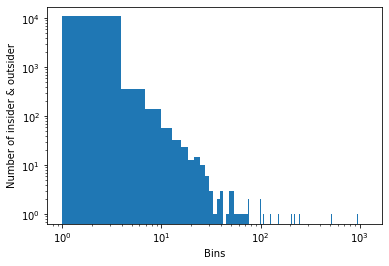

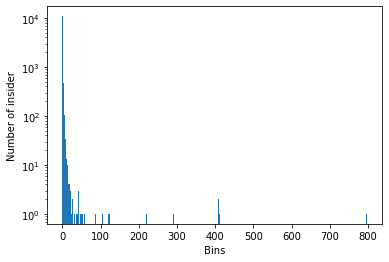

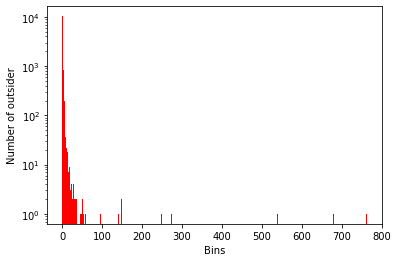

In [9]:
print("Number of pulled entities:", len(ents))
histo = []
histo_insider = []
histo_outsider = []
val_i = 0
val_o = 0

for k in ents:
    val_i = 0
    val_o = 0
    histo.append(len(ents[k]))
    for ent in ents[k]:
            if ent == "INSIDER":
                val_i += 1
            elif ent == "OUTSIDER":
                val_o += 1
    histo_insider.append(val_i)
    histo_outsider.append(val_o)

import matplotlib.pyplot as plt
plt.hist(histo, bins=400)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Bins")
plt.ylabel("Number of insider & outsider")
plt.show()

plt.hist(histo_insider, bins=400)
plt.yscale("log")
plt.xlabel("Bins")
plt.ylabel("Number of insider")
plt.show()

plt.hist(histo_outsider, bins=400, color='r')
plt.yscale("log")
plt.xlabel("Bins")
plt.ylabel("Number of outsider")
plt.show()

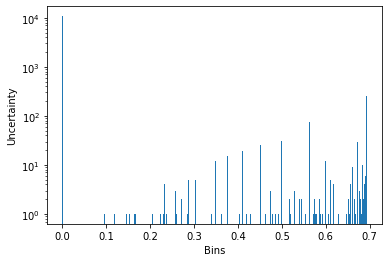

In [10]:
import math
ents_counts = {}
uncertainty = {}
for k in ents:
    values = ents[k]
    if k not in ents_counts:
        ents_counts[k] = (0.00001,0.00001)
    for v in values:
        if v == "INSIDER":
            ents_counts[k] = (ents_counts[k][0] + 1, ents_counts[k][1])
        elif v == "OUTSIDER":
            ents_counts[k] = (ents_counts[k][0], ents_counts[k][1] + 1)
    # compute binary cross entropy
    uncertainty[k] = -(ents_counts[k][0]/len(values))*math.log(ents_counts[k][0]/len(values)) - (ents_counts[k][1]/len(values))*math.log(ents_counts[k][1]/len(values))
plt.hist(uncertainty.values(), bins=400)    
plt.xlabel("Bins")
plt.ylabel("Uncertainty")
plt.yscale("log")
plt.show() 

In [11]:
i = 0
for k in uncertainty:
    if i < 50:
        if uncertainty[k] > 0.5:
            print(k, end=", ")
            print(ents_counts[k], end=", ")
    i += 1

people, (292.00001, 140.00001), the world, (30.00001, 22.00001), a vaccine, (99.00001, 147.00001), it, (411.00001, 762.00001), the truth, (6.00001, 17.00001), everyone, (80.00001, 28.00001), you, (409.00001, 539.00001), your vaccine, (3.00001, 6.00001), every one, (1.00001, 1.00001), the name, (3.00001, 7.00001), she, (17.00001, 36.00001), the stage, (1.00001, 1.00001), mind, (4.00001, 2.00001), 

In [12]:
i = 0
for k in uncertainty:
    if i < 500:
        if uncertainty[k] < 0.1 and len(ents[k]) > 3:
            print(k, end=", ")
            print(ents_counts[k], end=", ")
    i += 1

a conspiracy theorist, (1e-05, 4.00001), this thing, (1e-05, 6.00001), the immune system, (12.00001, 1e-05), the research, (1e-05, 4.00001), no big deal, (1e-05, 4.00001), reactions, (1e-05, 4.00001), the hospital, (1e-05, 7.00001), numbers, (1e-05, 5.00001), covid, (3.00001, 149.00001), lockdowns, (1e-05, 14.00001), government, (1e-05, 5.00001), that shit, (1e-05, 6.00001), a sub-human class, (1e-05, 4.00001), undesirables, (1e-05, 4.00001), camps, (1e-05, 4.00001), lies, (1e-05, 7.00001), china, (1e-05, 32.00001), this virus, (1e-05, 17.00001), a virus, (1e-05, 27.00001), the first time, (6.00001, 1e-05), the disease, (1e-05, 24.00001), the government, (1e-05, 50.00001), the mainstream media, (1e-05, 6.00001), control, (1e-05, 12.00001), the fda, (1e-05, 13.00001), the death, (1e-05, 8.00001), the trials, (6.00001, 1e-05), bell's palsy, (1e-05, 4.00001), me, (219.00001, 1e-05), microchips, (1e-05, 7.00001), your immune system, (21.00001, 1e-05), the virus, (2.00001, 96.00001), a vide

In [13]:
import pickle
var = pickle.load(open("/mnt/SSD2/pholur/CTs/Pickles/train_dataset.pkl", "rb"))


In [14]:
from copy import deepcopy
i = 0
train_ents = {}
for k,v in var.items():
        # each tuple in the list is an entity
        for place in v:
            poses = place[0]
            for p in poses:
                key_real = k[p[0]:p[1]]
                if key_real not in train_ents:
                    train_ents[key_real] = (0,0)
                if place[1] == 0:
                    train_ents[key_real] = (train_ents[key_real][0] + 1, train_ents[key_real][1])
                elif place[1] == 2:
                    train_ents[key_real] = (train_ents[key_real][0], train_ents[key_real][1] + 1)

train_ents_cleaned = deepcopy(train_ents)
for k in train_ents:
    if train_ents_cleaned[k][0] == 0 and train_ents_cleaned[k][1] == 0:
        del train_ents_cleaned[k]

In [15]:
print(len(train_ents_cleaned))

718


In [16]:
final_dict = set(train_ents_cleaned.keys() & ents_counts.keys())
print(len(ents_counts))

11568


In [17]:
for k,v in train_ents_cleaned.items():
    if k not in ents_counts:
        print(k, end=", ")

kinda, inviting, co-morbidities, just objectively shit, prize livestock, little chance schools, too much money, organ failure, fact check, generally side effects, the vaccine rollout, - experimental gene therapy, that poop, derived polio, my hr rep, lying coward, the word conspiracist, then all of a sudden become, compliant worker, issac, rigorous testing, 666the beginning, the day biden, every living thing, defense lawyer, greater, some lunatic, zero, pro trump or pro pharma, many many words, their life altering properties, vaccine antibodies, bipartisan wall st, ;, tick-borne encephalitis, the battery, federal relief checks, respond, the back end, /s, four days, know, the banker, god damn cloth muh freedoms, even what, 19 revolution, population decrease, that charles darwin, hence the vaccine, an invisible qr tattoo, nuts, a whole but weakened virus, pro mask, a messy year, about one case, 

In [33]:
new_dict = {}
for k,v in ents_counts.items():
    if k not in train_ents_cleaned:
            new_dict[k] = v

In [45]:
print(list(new_dict.keys())[:50])
print(len(new_dict))

['any journalist', 'unlawful or harmful acts', 'some group', 'no one', 'a journalist', 'the word conspiracy theorist', 'fake media', 'dw', 'john f kennedy', 'all those conspiracy theories', 'wrong dw', 'your answer', 'poverty', 'such a kind heart', 'your wealth', 'fate', 'your vaccine', 'this thing', 'every one', 'the immune system', 'a possibility', 'an autoimmune disease', 'the 80s', 'some lady', 'the name', 'her work', 'the industry', 'a long time', 'a venture capitalist company', 'its infancy', 'the 49k', 'the final version', 'the stage', '3 trials', 'mind', 'a substantial placebo group', 'the numbers', 'some pregnant people', 'their doctors', 'very little people', 'medical world', 'ivermectin', 'get covid', 'living', 'vs', 'experiment', 'the protein', 'your dna', 'oh and billions', 'literally 10$ prescription']
10905


In [69]:
uncertainty_extra = []
values_extra = []
color = []
names = []
for k in new_dict:
    # add entropy of each value tuple to uncertainty_extra
    uncertainty_extra.append(uncertainty[k])
    # append difference of values tuple to values_extra
    values_extra.append(new_dict[k][0] - new_dict[k][1])
    if new_dict[k][0] > new_dict[k][1]:
        color.append("blue")
    else:
        color.append("red")
    names.append(k)

print(len(names))
import numpy as np
import plotly.express as px
fig = px.scatter(y=np.random.uniform(low=-20.0, high=+20.0, size=(len(values_extra),)), color=values_extra, x=np.array(values_extra), hover_name=names, \
    opacity=0.5, range_x=[-30,30], range_y=[-20.2,20.2], color_continuous_scale=px.colors.sequential.RdBu, range_color=[-10,10], title="")
fig.layout.template = 'plotly' # dont change the template
fig.write_html("extra_entities.html")
fig.show()

10905
